In [1]:
from pickle import load
from math import ceil
from numpy.random import choice
from keras import Model, Sequential
from keras.applications import ResNet152V2
from keras.layers import Input, Dense, LSTM, Embedding, Add, Concatenate, Dropout
from keras.optimizers import Adam
from keras.losses import SparseCategoricalCrossentropy, BinaryCrossentropy
from keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

from tensorflow import GradientTape, zeros, ones, concat, cast
from tensorflow.data import Dataset, AUTOTUNE

from tensorflow import data, zeros, int32, float32, tensor_scatter_nd_add, constant, convert_to_tensor

from functions.text_processing import create_vocab_mappings
from functions.training import data_generator
from functions.model_evaluation import evaluate_captions, generate_and_evaluate_caption

from keras.losses import binary_crossentropy, sparse_categorical_crossentropy 
import tensorflow
from tensorflow import reduce_mean
from tensorflow import data, zeros, int64, float32, tensor_scatter_nd_add, constant, convert_to_tensor
from tensorflow.math import argmax

from keras_tuner import HyperModel, BayesianOptimization
from keras.callbacks import TensorBoard, EarlyStopping


from numpy import expand_dims, mean
from keras.utils import pad_sequences
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from nltk.translate.meteor_score import meteor_score

from functions.model_evaluation import decode_caption




[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\james\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
SEQ_LENGTH = 15
EMB_DIM = 300 # can only be values 100, 200, 300
HIDDEN_DIM = 512
EPOCHS = 100
DROPOUT = 0.4
BATCH_SIZE = 512
EVAL_BATCH_SIZE = 1024
DIR = 'preprocessed_data/coco/'

In [3]:
with open(DIR + 'train_caption_map.pkl', 'rb') as file:
    train_caption_map = load(file)
    
with open(DIR + 'train_feature_map.pkl', 'rb') as file:
    train_feature_map = load(file)

with open(DIR + 'val_caption_map.pkl', 'rb') as file:
    val_caption_map = load(file)
    
with open(DIR + 'val_feature_map.pkl', 'rb') as file:
    val_feature_map = load(file)

with open(DIR + 'embedding_matrix.pkl', 'rb') as file:
    embedding_matrix = load(file)
    
with open(DIR + 'vocab.pkl', 'rb') as file:
    vocab = load(file)
    
train_images = list(train_caption_map.keys())
val_images = list(val_caption_map.keys())

VOCAB_SIZE = len(vocab)
STEPS = ceil(len(train_images) * 5 / BATCH_SIZE)
VAL_STEPS = ceil(len(val_images) * 5 / BATCH_SIZE)

word_to_idx, idx_to_word = create_vocab_mappings(vocab)

train_data = data_generator (train_images, train_caption_map, train_feature_map, BATCH_SIZE)
val_data = data_generator(val_images, val_caption_map, val_feature_map, BATCH_SIZE)

In [4]:
def create_dataset(images, image_features, image_captions):
    features, input_captions, target_captions = [], [], []
    for image in images: 
        current_features = image_features[image]
        for caption in image_captions[image]:
            features.append(current_features)
            input_captions.append(caption[:-1])
            target_captions.append(caption[1:])
            break
        
    dataset = Dataset.from_tensor_slices((features, input_captions, target_captions))
    dataset = dataset.shuffle(BATCH_SIZE).batch(BATCH_SIZE, drop_remainder=True).prefetch(AUTOTUNE)
    return dataset

In [5]:
train_dataset = create_dataset(train_images, train_feature_map, train_caption_map)
val_dataset = create_dataset(val_images, val_feature_map, val_caption_map)

In [6]:
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from nltk.translate.meteor_score import meteor_score
# from numpy import mean 

from functions.model_evaluation import decode_caption, decode_captions

In [7]:
class Generator(Model):
    def __init__(self, sequence_len, image_size, vocab_size, hidden_dim_1, hidden_dim_2, embedding_dim, embedding_matrix, dropout):
        super().__init__()
        self.sequence_length = sequence_len
        self.batch_size = BATCH_SIZE
        # image layers 
        self.image_input = Input(shape= (image_size,))    
        self.image_dropout =  Dropout(dropout)
        self.image_dense = Dense(hidden_dim_1, activation = 'relu')
        # sequence layers
        self.sequence_input = Input(shape= (sequence_len,))
        self.sequence_embedding = Embedding(vocab_size, embedding_dim, input_length = sequence_len, trainable=False, weights = [embedding_matrix])
        self.embedding_dropout = Dropout(dropout)
        self.lstm = LSTM(hidden_dim_1, return_sequences = True)
        # prediction layers
        self.merging = Add()
        self.merging_dropout = Dropout(dropout)
        self.dense = Dense(hidden_dim_2, activation ='relu')
        self.dense_dropout = Dropout(dropout)
        self.vocab_prediction = Dense(vocab_size, activation='softmax')
        
    def call(self, data):
        image_features, caption = data 
        
        # image path
        image = self.image_dropout(image_features)
        image = self.image_dense(image)
        # sequence path
        sequence = self.sequence_embedding(caption)
        sequence = self.embedding_dropout(sequence)
        sequence = self.lstm(sequence)
        # prediction path 
        output = self.merging([image, sequence])
        output = self.merging_dropout(output)
        output = self.dense(output)
        output = self.dense_dropout(output)
        output = self.vocab_prediction(output)
        return output 
    
    def evaluate_captions(self, image_features, real_captions):
        meteor_score = []
        bleu_score = []
        weights = [(1.,), (1./2., 1./2.), (1./3., 1./3., 1./3.), (1./4., 1./4., 1./4., 1./4.)]
        smoothing_function = SmoothingFunction() 

        fake_captions = self.generator.generate_captions(image_features)
        
        fake_captions = decode_captions(fake_captions, idx_to_word)
        real_captions = [decode_captions(caption) for caption in real_captions]
        
        for pred, true in zip(fake_captions, real_captions):
            bleu_score.append(sentence_bleu(true, pred, weights, smoothing_function)) # should swap to corpus bleu
            meteor_score.append(meteor_score(true, pred))
        
        bleu = [mean(bleu_score[:, 0]), mean(bleu_score[:, 1]), mean(bleu_score[:, 2]), mean(bleu_score[:, 3])]
        meteor = mean(meteor)
        return bleu, meteor
    
    def generate_captions(self, list_of_features): # shold be changed to deal with adaptive batch size 
        batch_size = list_of_features.shape[0]
        captions = zeros([batch_size, self.sequence_length], dtype=int64)
        start_token = constant([3] * batch_size, dtype=int64)
        indices = [[i, 0] for i in range(batch_size)]
        captions = tensor_scatter_nd_add(captions, indices, start_token)
        features = convert_to_tensor(list_of_features)
        
        for i in range(self.sequence_length - 1):
            prediction = self([features, captions])
            updates = argmax(prediction[:, i, :], axis=1)
            indices = [[j, i + 1] for j in range(batch_size)]
            captions = tensor_scatter_nd_add(captions, indices, updates)
        return captions
    
    def generate_caption(self, features):
        features = expand_dims(features, axis=0)
        captions = zeros([1, self.sequence_length], dtype=int64)
        start_token = constant([3], dtype=int64)  
        indices = constant([[0, 0]], dtype=int64)
        captions = tensor_scatter_nd_add(captions, indices, start_token)
        
        for i in range(self.sequence_length - 1):
            prediction = self([features, captions])
            updates = argmax(prediction[:, i, :], axis=1)
            indices = [[0, i+1]]
            captions = tensor_scatter_nd_add(captions, indices, updates)
        return captions
    
    

In [8]:
class Discriminator(Model):
    def __init__(self, sequence_len, image_shape, vocab_size, hidden_dim, embedding_dim, embedding_matrix, dropout):
        super().__init__()
        # image layers
        self.image_input = Input(shape= image_shape)    
        self.image_dropout =  Dropout(dropout)
        self.image_dense = Dense(hidden_dim, activation = 'relu')
        # sequence layers
        self.sequence_input = Input(shape= sequence_len)
        self.sequence_embedding = Embedding(vocab_size, embedding_dim, input_length = SEQ_LENGTH, trainable=False, weights = [embedding_matrix])
        self.embedding_dropout = Dropout(dropout)
        self.lstm = LSTM(hidden_dim)
        #prediction layers
        self.merging = Concatenate()
        self.merging_dropout = Dropout(dropout)
        self.dense = Dense(hidden_dim, activation ='relu')
        self.dense_dropout = Dropout(dropout)
        self.prediction = Dense(1, activation='sigmoid')
        
    def call(self, image_features, caption):
        # image path
        image = self.image_dropout(image_features)
        image = self.image_dense(image)
        # sequence path
        sequence = self.sequence_embedding(caption)
        sequence = self.embedding_dropout(sequence)
        sequence = self.lstm(sequence)
        # prediction path 
        output = self.merging([image, sequence])
        output = self.merging_dropout(output)
        output = self.dense(output)
        output = self.dense_dropout(output)
        output = self.prediction(output)
        return output

In [9]:
class GANHyperModel(HyperModel):
    def __init__(self, embedding_matrix, sequence_len=20, feature_size=1280, vocab_size=4096, embedding_dim=300):
        super().__init__()
        self.embedding_matrix = embedding_matrix
        self.sequence_len = sequence_len
        self.feature_size = feature_size 
        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        
    def build(self, hp):
        generator_dropout = hp.Float('generator_dropout', min_value=0.0, max_vlaue)
        self.generator = Generator(self.sequence_len, self.feature_size, self.vocab_size, hidden_dim, self.embedding_dim, self.embedding_matrix, dropout)
        
    def call(self, inputs, training=False):
        image_features, input_captions = inputs
        return self.generator([image_features, input_captions], training=training)
    
    def train_step(self, inputs):
        image_features, input_captions, target_captions = inputs
        batch_size = BATCH_SIZE
        
        # training the discriminator 
        target_captions = cast(target_captions, dtype=int32)
        true_labels = ones((batch_size, 1))
        fake_lables = zeros((batch_size, 1))
        
        with GradientTape() as discriminator_tape: 
            # predicted_captions = self.generator.generate_captions(image_features, seq_len=15, batch_size=batch_size)    
            
            generator_predictions = self.generator([image_features, input_captions])
            
            generated_caption = argmax(generator_predictions, axis=-1)
                
            true_predictions = self.discriminator(image_features, target_captions)
            fake_predictions = self.discriminator(image_features, generated_caption)
                        
            real_loss = binary_crossentropy(true_labels, true_predictions)
            fake_loss = binary_crossentropy(fake_lables, fake_predictions)
            
            discriminator_loss = 0.5 * (real_loss + fake_loss)
        
        discriminator_gradients = discriminator_tape.gradient(discriminator_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(zip(discriminator_gradients, self.discriminator.trainable_weights))
        
        with GradientTape() as generator_tape:
            misleading_labels = ones((batch_size, 1))
            # predicted_captions = self.generator.generate_captions(image_features, seq_len=15, batch_size=batch_size)   
                 
            generator_predictions = self.generator([image_features, input_captions])
            generated_caption = argmax(generator_predictions, axis=-1)
            caption_loss = sparse_categorical_crossentropy(target_captions, generator_predictions)
            
            discriminator_predictions = self.discriminator(image_features, generated_caption)
            adversarial_loss = binary_crossentropy(misleading_labels, discriminator_predictions)
                    
            generator_loss = reduce_mean(caption_loss) * self.alpha + reduce_mean(discriminator_loss) * self.beta
                        
        generator_gradients = generator_tape.gradient(generator_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(generator_gradients, self.generator.trainable_weights))
        
        return {'discriminator_loss': discriminator_loss, 'generator_loss': generator_loss, 'caption_loss': caption_loss, 'adversarial_loss': adversarial_loss}
    
    def test_step(self, inputs):
        image_features, input_captions, target_captions = inputs
        batch_size = BATCH_SIZE
        
        target_captions = cast(target_captions, dtype=int32)
        
        predicted_captions = self.generator([image_features, input_captions])
        caption_loss = sparse_categorical_crossentropy(target_captions, predicted_captions)
        
        generated_captions = self.generator.generate_captions(image_features) 
        
        true_labels = ones((batch_size, 1))
        fake_lables = zeros((batch_size, 1))  
             
        true_predictions = self.discriminator(image_features, target_captions)
        fake_predictions = self.discriminator(image_features, generated_captions)
        
        real_loss = binary_crossentropy(true_labels, true_predictions)
        fake_loss = binary_crossentropy(fake_lables, fake_predictions)
        
        discriminator_loss = 0.5 * (real_loss + fake_loss)
                        
        generator_loss = reduce_mean(caption_loss) * self.alpha + reduce_mean(discriminator_loss) * self.beta
        
        return {'discriminator_loss': discriminator_loss, 'generator_loss': generator_loss, 'caption_loss': caption_loss}

In [ ]:
class GANHyperModel(HyperModel):
    def __init__(self, embedding_matrix, sequence_len=20, feature_size=1280, vocab_size=4096, embedding_dim=300):
        super().__init__()
        self.embedding_matrix = embedding_matrix
        self.sequence_len = sequence_len
        self.feature_size = feature_size 
        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        
    def build(self, hp):
        self.alpha = hp.Float('alpha', min_value=0.5, max_value=2.0, step=0.1)
        self.beta = hp.Float('beta', min_value=0.5, max_value=2.0, step=0.1)
        gen_dropout = hp.Float('gen_dropout', min_value=0.0, max_value=0.5, step=0.1)
        gen_hidden_dim = hp.Choice('gen_hidden_dim', values=[256, 512, 1024])
        gen_pred_dim = hp.Choice('gen_pred_dim', values=[256, 512, 1024])
        self.generator = Generator(self.sequence_len, self.feature_size, self.vocab_size, gen_hidden_dim, gen_pred_dim, self.embedding_dim, self.embedding_matrix, gen_dropout)
        
        disc_dropout = hp.Float('disc_dropout', min_value=0.0, max_value=0.5, step=0.1)
        disc_hidden_dim = hp.Choice('disc_hidden_dim', values=[256, 512, 1024])
        self.discriminator = Discriminator(self.sequence_len, self.feature_size, self.vocab_size, disc_hidden_dim, self.embedding_dim, self.embedding_matrix, disc_dropout)

In [14]:
# Initialize hypermodel
hypermodel = GANHyperModel(embedding_matrix)

# Initialize tuner
tuner = BayesianOptimization(
    hypermodel,
    objective="val_loss", 
    max_trials=500,  
    directory="keras_tuning",
    project_name="gan_tuning", 
)

# Initializing tensorborad callback 
tensorboard = TensorBoard(
    log_dir='./tensorboard_logs/gan_tuning',
    histogram_freq=1,
    write_graph=True,
    update_freq='epoch'
)

In [15]:
# Searching for optimal solution 
tuner.search(
    train_data,
    epochs = 3,
    steps_per_epoch=STEPS,
    validation_data=val_data,
    validation_steps=VAL_STEPS,
    callbacks= [tensorboard],
    verbose=1
)


Search: Running Trial #1

Value             |Best Value So Far |Hyperparameter
1.1               |1.1               |alpha
0.6               |0.6               |beta
0                 |0                 |gen_dropout
256               |256               |gen_hidden_dim
512               |512               |gen_pred_dim
0                 |0                 |disc_dropout
256               |256               |disc_hidden_dim



FatalTypeError: Expected the model-building function, or HyperModel.build() to return a valid Keras Model instance. Received: None of type <class 'NoneType'>.

In [11]:
# fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# # Plotting Generator Loss
# axes[0, 0].plot(training.history['generator_loss'], marker='o', color='b', label='Generator Loss')
# axes[0, 0].plot(training.history['val_generator_loss'], marker='o', color='r', label='Validation Generator Loss')
# axes[0, 0].set_title('Generator Loss')
# axes[0, 0].set_xlabel('Epochs')
# axes[0, 0].set_ylabel('Loss')
# axes[0, 0].legend()

# # Plotting Discriminator Loss
# axes[0, 1].plot(training.history['discriminator_loss'], marker='o', color='g', label='Discriminator Loss')
# axes[0, 1].plot(training.history['val_discriminator_loss'], marker='o', color='orange', label='Validation Discriminator Loss')
# axes[0, 1].set_title('Discriminator Loss')
# axes[0, 1].set_xlabel('Epochs')
# axes[0, 1].set_ylabel('Loss')
# axes[0, 1].legend()

# # Plotting Caption Loss
# axes[1, 0].plot(training.history['caption_loss'], marker='s', color='purple', label='Caption Loss')
# axes[1, 0].plot(training.history['val_caption_loss'], marker='s', color='pink', label='Validation Caption Loss')
# axes[1, 0].set_title('Caption Loss')
# axes[1, 0].set_xlabel('Epochs')
# axes[1, 0].set_ylabel('Loss')
# axes[1, 0].legend()

# # Plotting Adversarial Loss
# axes[1, 1].plot(training.history['adversarial_loss'], marker='D', color='brown', label='Adversarial Loss')
# axes[1, 1].plot(training.history['val_adversarial_loss'], marker='D', color='cyan', label='Validation Adversarial Loss')
# axes[1, 1].set_title('Adversarial Loss')
# axes[1, 1].set_xlabel('Epochs')
# axes[1, 1].set_ylabel('Loss')
# axes[1, 1].legend()

# plt.tight_layout()
# plt.show()

In [12]:
def create_eval_dataset(images, image_features, image_captions):
    features, target_captions = [], []
    for image in images: 
        current_features = image_features[image]
        current_captions = []
        
        for caption in image_captions[image]:
            if (len(current_captions) >= 5):
                print('caption', len(current_captions),  'skipped from image ', image)
                break
            current_captions.append(convert_to_tensor(caption))
                
        features.append(current_features)
        target_captions.append(current_captions)
        
    dataset = Dataset.from_tensor_slices((features, target_captions))
    dataset = dataset.shuffle(BATCH_SIZE).batch(BATCH_SIZE, drop_remainder=True).prefetch(AUTOTUNE)
    return dataset

# eval_dataset = create_eval_dataset(val_images, val_feature_map, val_caption_map)

In [13]:
predicted_captions, true_captions = batch_generate_captions(val_images, val_feature_map, val_caption_map, idx_to_word, SEQ_LENGTH, 1024)
evaluate_captions(predicted_captions, true_captions)

NameError: name 'batch_generate_captions' is not defined

- training 1 = 
    - ([0.6324413703359115,
  0.43886291301506847,
  0.2887201167362333,
  0.19700841825968338],
 0.418904394023797) (wrong smoothing method used )
 - training 2, 91 epochs, 
    - ([0.5553526812523059,
  0.35532181655896167,
  0.22918829113361136,
  0.15546927729921756],
 0.36831939230308525)
- training 3, 16 epoch, discrim hid_dim doubled
  - ([0.6369256956989295,
  0.4477340858496782,
  0.3058138450452782,
  0.21467512174022885],
 0.41646065200044774)
- training 4, 30 epochs, alpha decreased to 0.1
    - ([0.6302390410278534,
  0.437418775235155,
  0.29614665149387964,
  0.20747113865267464],
 0.4127004608071282)
- training 5, 30 epochs 
  - ([0.6274449040871883,
  0.436262207094143,
  0.29650737714987624,
  0.20792691376261457],
 0.41837383253870913)

In [ ]:
generator.save('models/gan-generator')


INFO:tensorflow:Assets written to: models/gan-generator\assets


INFO:tensorflow:Assets written to: models/gan-generator\assets


INFO:tensorflow:Assets written to: models/gan-discriminator\assets


INFO:tensorflow:Assets written to: models/gan-discriminator\assets


In [ ]:
from keras.models import load_model

test_model = load_model('models/gan-generator')

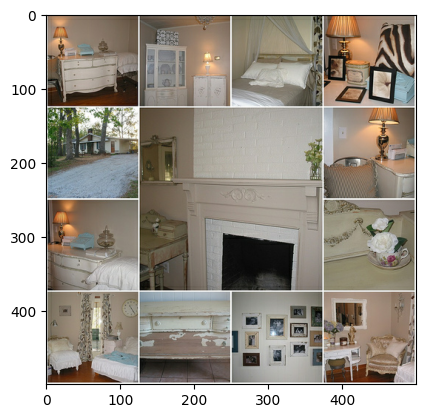

Predicted caption:


ValueError: in user code:

    File "c:\Projects\coursework\.venv\lib\site-packages\keras\engine\training.py", line 2041, in predict_function  *
        return step_function(self, iterator)
    File "c:\Projects\coursework\.venv\lib\site-packages\keras\engine\training.py", line 2027, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Projects\coursework\.venv\lib\site-packages\keras\engine\training.py", line 2015, in run_step  **
        outputs = model.predict_step(data)
    File "c:\Projects\coursework\.venv\lib\site-packages\keras\engine\training.py", line 1983, in predict_step
        return self(x, training=False)
    File "c:\Projects\coursework\.venv\lib\site-packages\keras\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None

    ValueError: Exception encountered when calling layer "generator" "                 f"(type Generator).
    
    Could not find matching concrete function to call loaded from the SavedModel. Got:
      Positional arguments (1 total):
        * (<tf.Tensor 'data:0' shape=(None, 2048) dtype=float32>,
     <tf.Tensor 'data_1:0' shape=(None, 15) dtype=int32>)
      Keyword arguments: {'training': False}
    
     Expected these arguments to match one of the following 4 option(s):
    
    Option 1:
      Positional arguments (1 total):
        * [TensorSpec(shape=(None, 2048), dtype=tf.float32, name='data/0'),
     TensorSpec(shape=(None, 15), dtype=tf.int64, name='data/1')]
      Keyword arguments: {'training': False}
    
    Option 2:
      Positional arguments (1 total):
        * [TensorSpec(shape=(None, 2048), dtype=tf.float32, name='data/0'),
     TensorSpec(shape=(None, 15), dtype=tf.int64, name='data/1')]
      Keyword arguments: {'training': True}
    
    Option 3:
      Positional arguments (1 total):
        * [TensorSpec(shape=(None, 2048), dtype=tf.float32, name='input_1'),
     TensorSpec(shape=(None, 15), dtype=tf.int64, name='input_2')]
      Keyword arguments: {'training': False}
    
    Option 4:
      Positional arguments (1 total):
        * [TensorSpec(shape=(None, 2048), dtype=tf.float32, name='input_1'),
     TensorSpec(shape=(None, 15), dtype=tf.int64, name='input_2')]
      Keyword arguments: {'training': True}
    
    Call arguments received by layer "generator" "                 f"(type Generator):
      • args=(('tf.Tensor(shape=(None, 2048), dtype=float32)', 'tf.Tensor(shape=(None, 15), dtype=int32)'),)
      • kwargs=<class 'inspect._empty'>


In [31]:
test_features = val_feature_map[test_image]

generate_and_evaluate_test_caption('datasets/coco/val2014/', test_image, test_features, true_captions, idx_to_word, test_model, SEQ_LENGTH)
